## Import necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use("ggplot")
%matplotlib inline

from sklearn.model_selection import KFold
import cv2

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras import utils

#unet collection
from keras_unet_collection import models
#import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import to_categorical
#Python 3.8.16 used


## General part

In [2]:
#define directory where images and masks are located on local disk
image_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images/' ##VGG16 needs seperate induction of path
mask_directory = 'D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_masks_RF/insert_masks/'   ##VGG16 need seperate induction of path

#define the properties and empty list for resized images and masks
SIZE = 256
image_dataset = []
mask_dataset = []

#define custom function
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

#enumerate and resize images/masks
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

#define some hyperparameters
num_labels = 1  #Binary classificaion
batch_size = 2  #keep it smaller than 3
epochs = 60
num_folds = 5   #define the number of folds (usually 5-10 folds)

#normalize images
image_dataset = np.array(image_dataset)/255
#do not normalize masks, just rescale to 0 to 1. Add RGB-Chanel (3) to mask.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255
mask_dataset = tf.keras.utils.to_categorical(mask_dataset)

#define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, random_state= 42 ,shuffle=True)

#define per-fold score containers 
acc_per_fold = []
loss_per_fold = []
IoU_per_fold = []

fold_no = 1

#determine best fold and create csv file
def best_fold(searchterm):
    fo_path = os.getcwd() 
    max_val_iou = 0.0
    fold = ""
    for file_name in os.listdir(fo_path):
        if searchterm in file_name and file_name.endswith(".csv"):
            file_path = os.path.join(fo_path, file_name)
            df = pd.read_csv(file_path)
            print(file_path)
            if "val_IoU" in df.columns:
                val_iou = df["val_IoU"].max()
            if val_iou > max_val_iou:
                max_val_iou = val_iou
                fold = file_name

    #save the results to a CSV file
    results = pd.DataFrame({"fold": [fold], "max_val_iou": [max_val_iou]})
    results.to_csv(f"{searchterm}results.csv", index=False)


## DL-Kfold with unet_2plus

In [ ]:
architecture = "unet_2plus"
for train, test in kfold.split(image_dataset, mask_dataset):

  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f"B1VL-Kfoldno{fold_no}-{architecture}.h5", verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f"B1VL-Kfoldno{fold_no}-{architecture}.csv", separator=",", append=False)]

  #define the model architecture
  #unet_plus_2d requires a Backbone
  model = models.unet_plus_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation="ReLU", 
                           output_activation="Sigmoid", 
                           batch_norm=False, pool=False, unpool=False, 
                           backbone="VGG16", weights="imagenet", 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name="unet_plus")

  #compile the model
  model.compile(loss="binary_crossentropy", optimizer=Adam(lr = 1e-3), 
              metrics=["accuracy", IoU])

  #generate a print
  print("------------------------------------------------------------------------")
  print(f"Training for fold {fold_no} ...")

  #fit model to data
  Unet_plus_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)
  
  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

fold_no = 1

#determine best fold
best_fold(architecture)

## DL-Kfold with unet_3plus

In [ ]:
architecture = "unet_3plus"
for train, test in kfold.split(image_dataset, mask_dataset):

  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-{architecture}.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-{architecture}.csv', separator=',', append=False)]

  # Define the model architecture
  # unet_plus_2d require depth >= 2
  model = models.unet_3plus_2d((256, 256, 3), n_labels=num_labels, filter_num_down=[64, 128, 256, 512, 1024], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool=True, unpool=False, deep_supervision=False, name='unet3plus')
  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  Unet_plus_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)
  
  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  # Increase fold number
  fold_no += 1

fold_no = 1

#determine best fold
best_fold(architecture)

## DL-Kfold with Trans_unet

In [ ]:
architecture = "Trans_unet"
for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-{architecture}.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-{architecture}.csv', separator=',', append=False)]
  
  #define the model architecture
  model = models.transunet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                          n_labels=num_labels, stack_num_down=2, stack_num_up=2, 
                          embed_dim=768, num_mlp=3072, num_heads=12, num_transformer=12, 
                          activation='ReLU', mlp_activation='GELU', output_activation='Sigmoid', #output activation from Softmax to Sigmoid
                          batch_norm=True, pool=True, unpool=False, name='transunet')
                          #batchnorm to true, unpool to false

  #compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model to data
  transunet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

fold_no = 1

#determine best fold
best_fold(architecture)

## DL-Kfold with Swin_unet

In [3]:
architecture = "Swin_unet"
for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-{architecture}.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-{architecture}.csv', separator=',', append=False)]
  
  #define the model architecture
  #this model requires depth >= 2
  model = models.swin_unet_2d((256, 256, 3), filter_num_begin=64, n_labels=num_labels, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(4, 4), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Softmax', shift_window=True, name='swin_unet') #Guess: Shift_window = False

  #compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model on data
  swin_unet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

#determine best fold
best_fold(architecture)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/60
  7/205 [>.............................] - ETA: 2:58 - loss: 7.6246 - accuracy: 0.5000 - IoU: 1.0000

KeyboardInterrupt: 

## VGG16 with DL-Kfold

Total no. of aponeurosis images =  512


TypeError: Invalid shape (256, 256, 1, 1) for image data

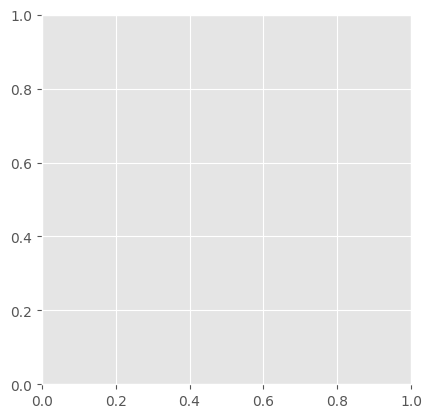

In [1]:

import os
import random
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets
import cv2

import tensorflow as tf

from keras.backend import clear_session
from keras import backend as K
from keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG16 
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs) #32
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    
    return x

def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor = inputs)
    #vgg16.summary()
    
    """ Encoder """
    
    # skip connections
    s1 = vgg16.get_layer("block1_conv2").output # 256
    s2 = vgg16.get_layer("block2_conv2").output # 128
    s3 = vgg16.get_layer("block3_conv3").output # 64
    s4 = vgg16.get_layer("block4_conv3").output # 32

    """ Bottleneck/Bridge """
    
    b1 = vgg16.get_layer("block5_conv3").output # 16
    
    """ Decoder """

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    """ Outputs """
    outputs = Conv2D(1, (1, 1), padding = "same", activation="sigmoid")(d4) #binary segmentation
    model = Model(inputs, outputs, name = "VGG16_U-Net")
    return model
    
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

def dice_score(y_true, y_pred, smooth=1):
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    
    return 1 - dice_score(y_true, y_pred)

def dice_bce_score(y_true, y_pred, smooth=1):    
    
    BCE =  K.binary_crossentropy(y_true, y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(y_true, -1) + K.sum(y_pred, -1) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2):    
      
    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

# Save all predictions on disk 
def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        plt.savefig(str(i)+"Pred_area.tif") # Saves images to directory of notebook

# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

def dice_score(y_true, y_pred, smooth=1):
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    
    return 1 - dice_score(y_true, y_pred)

def dice_bce_score(y_true, y_pred, smooth=1):    
    
    BCE =  K.binary_crossentropy(y_true, y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(y_true, -1) + K.sum(y_pred, -1) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2):    
      
    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

# Save all predictions on disk 
def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        plt.savefig(str(i)+"Pred_area.tif") # Saves images to directory of notebook
    
# Images will be re-scaled
im_width = 256
im_height = 256
border = 5

# list of all images in the path
ids = os.listdir('D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images/')
print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

image_dataset = []
for path in glob.glob('D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_images_RF/insert_images/'):
    for img_path in glob.glob(os.path.join(path, "*.tif")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (256,256))
        img = img_to_array(img)
        img = img/255.0
        image_dataset.append(img)  
image_dataset = np.array(image_dataset)

mask_dataset = []
for path in glob.glob('D:/UniBas/Bachelorarbeit/Img_masks/DeepACSA_masks_RF/insert_masks/'):
    for mask_path in glob.glob(os.path.join(path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256,256))
        mask = img_to_array(mask)
        mask = mask/255.0
        mask_dataset.append(mask)
        
mask_dataset = np.array(mask_dataset)
mask_dataset = np.expand_dims(mask_dataset, axis=3)

###################################################################################
batch_size = 2
epochs = 60
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=False)

# Define per-fold score containers 
acc_per_fold = []
loss_per_fold = []

#compile the model
VGG16_UNet = build_vgg16_unet((256,256,3)) #input_shape is (256, 256, 3)
model_apo = VGG16_UNet
model_apo.compile(optimizer=Adam(), loss=dice_bce_score, metrics=["accuracy", IoU])

# K-fold Cross Validation model evaluation
fold_no = 1
architecture = "VGG16"
for train, test in kfold.split(image_dataset, mask_dataset):

  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-{architecture}.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-{architecture}.csv', separator=',', append=False)
  ]

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  results = model_apo.fit(image_dataset[train], mask_dataset[train], batch_size=batch_size, epochs=epochs,
                       callbacks=callbacks, validation_data=(image_dataset[test], mask_dataset[test]))

  # Increase fold number
  fold_no = fold_no + 1

fold_no = 1

#determine best fold
best_fold(architecture)

## DL-Kfold with ResUnet (not working)

In [ ]:
architecture = "ResUnet"
for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-{architecture}.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-{architecture}.csv', separator=',', append=False)]

  # Define the model architecture
  # resunet requires depth >= 2
  resunet = models.resunet_a_2d((256, 256, 3), [64, 128, 256, 512], 
                            dilation_num=[1, 3, 15, 31], 
                            n_labels=2, aspp_num_down=256, aspp_num_up=128, 
                            activation='ReLU', output_activation='Softmax', 
                            batch_norm=True, pool="max", unpool='nearest', name='resunet')

  # Compile the model
  resunet.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  resunet_history = resunet.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(resunet.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(resunet.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(resunet.evaluate(image_dataset[test], mask_dataset[test])[2])

  # Increase fold number
  fold_no += 1

fold_no = 1

#determine best fold
best_fold(architecture)

## DL-Kfold with r2_unet (not working)

In [ ]:
architecture = "r2_unet"
for train, test in kfold.split(image_dataset, mask_dataset):
  callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(f'B1VL-Kfoldno{fold_no}-{architecture}.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger(f'B1VL-Kfoldno{fold_no}-{architecture}.csv', separator=',', append=False)]                                  # Give the CSV file a name (.csv)

  #define the model architecture
  #r2_unet_2d requires depth >= 2
  model = models.r2_unet_2d((256, 256, 3), [64, 128, 256, 512], n_labels=num_labels,
                          stack_num_down=2, stack_num_up=2, recur_num=2,
                          activation='ReLU', output_activation='Softmax', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

  #compile the model
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', IoU])

  #generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  #fit model on data
  resunet_history = model.fit(image_dataset[train], mask_dataset[train], 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(image_dataset[test], mask_dataset[test]), 
                    shuffle=False,
                    epochs=epochs,
                    callbacks=callbacks)

  #append evaluation values for every fold to a list
  acc_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[1])
  loss_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[0])
  IoU_per_fold.append(model.evaluate(image_dataset[test], mask_dataset[test])[2])

  #increase fold number
  fold_no += 1

fold_no = 1

#determine best fold
best_fold(architecture)

## Provide average scores for K-fold cross validation (outdated)

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]} - IoU: {IoU_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> IoU: {np.mean(IoU_per_fold)}')
print('------------------------------------------------------------------------')